<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">pyVIRUS</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);"><b style=color:red;>Virus</b> modelling</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
<td><img style="height: 150px;" src="images/pyVIRUS.png"></td>
</tr>
</table>

----
# `pyVIRUS`

pyVIRUS, a program package for for modelling the spread and containment of a virus in a population.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import ipywidgets as widgets

----
# Evolution models (SIR)
In this notebook, we look into virus modelling with coupled differential equations.
This setup is actually very similar to our geoscientific decay-series modeling for radiogenic isotopes!

# <a id="SIR">SIR model</a>

The **SIR** model describes how an infection spreads in a population from **healty** individuals via 
**infected** persons to **immune** people. 

**SIR** stands for **Susceptible – Infectious – Recovered**, it is a box model. 


We define `N` as the total number of individuals. Then we sub-divide:
- $S(t)$: Number of **susceptible** people [1/number]
- $I(t)$: Number of **invected** people [1/number]
- $R(t)$: Number of **recovered** people [1/number]
with $t$ the time.

For the total number of people $N$, we define:
$$
N = S(t)+I(t)+R(t)
$$

During the invection, people move from compartment `S` via compartment `I` to compartment `R`.
This is described by the following set of **coupled ordinary differential equation of first order**:
$$
\begin{array}{rcl}
{{dS} \over {dt}} & = & - \lambda(I) S \\
{{dI} \over {dt}} & = & + \lambda(I) S - \gamma I \\
{{dR} \over {dt}} & = & + \gamma I \\
\end{array}
$$
with 
- $\lambda$ [1/day] the **infection rate** 
- $\gamma$ [1/day] the **recovery rate**

The invection rate itself is a function of $I$:
$$
\lambda = \beta I,
$$
with $\beta$ [1/number/day] the **transmission rate**, often called $R_0$ in the literature.

We start defining the differential equations of the SIR model as function `rhs`:

In [14]:
def rhsSIR1(t,y, beta, gamma):
    """
    """
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt,dIdt,dRdt]

Next, we need **initial conditions**, the **time** array, and then solve the differential equation with
`odeint` from the `scipy.integrate` package. We pack all three parts into a function `SIRmodel`, and
add plotting commands:

In [15]:
def runSIR1(beta,gamma,tmax=50,N=50):
    """
    """
    # Total population, N.
    # Initial number of infected and recovered individuals, I0 and R0.
    I0, R0 = 1, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    #beta, gamma = 2.2, 1./28
    # A grid of time points (in days)
    t = np.linspace(0, tmax, 5*tmax)
    # The SIR model differential equations.
    # Initial conditions vector
    y0 = [S0, I0, R0]
    # Integrate the SIR equations over the time grid, t.
    solution = integrate.solve_ivp(rhsSIR1,[t[0],t[-1]],y0,t_eval=t, args=(beta, gamma))
    S, I, R = solution.y
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    plt.figure(figsize=(10.0,6.0))
    plt.xlabel('Time [days]')
    plt.ylabel('People [#]')
    plt.ylim([0,1.1*N])
    plt.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    plt.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
    plt.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered')
    plt.grid(which='major', c='lightgrey', lw=1, ls=':')
    plt.legend()


We test is model manually. We therefore need estimates for $S_0$ and $I_0$, as well as the
rates $\beta$ and $\gamma$.

We use as example a small school, with $N=50$ pupils. One is infected initially ($I_0=1$).

The invection rate $\beta$ we derive from the spread of the infection during a day:
- On one day, 40 pupils are susceptible, 8 are infected.
- On the next day, 30 pupils are susceptible, and 18 infected.
- On the next day, 3 previously infected have recovered.

Then $\beta$ is derived as ratio *decrease in susceptible* to the product of *susceptible* and *infected*,
the latter the potential pairs, the former the real pairs:
$$
\beta = \frac{10}{40*8}
$$
And $\gamma$ describes the ration of *recovered* to *infected* pupils:
$$
\gamma = \frac{3}{15}
$$

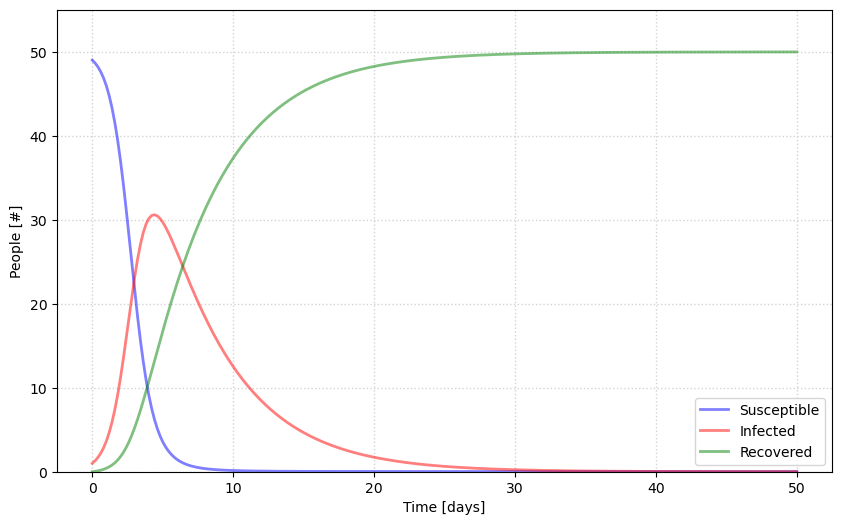

In [16]:
beta  = 10 / (40*8)
gamma = 3/15
runSIR1(beta,gamma,N=50)

Decreasing $\beta$ means slowing the infection rate:

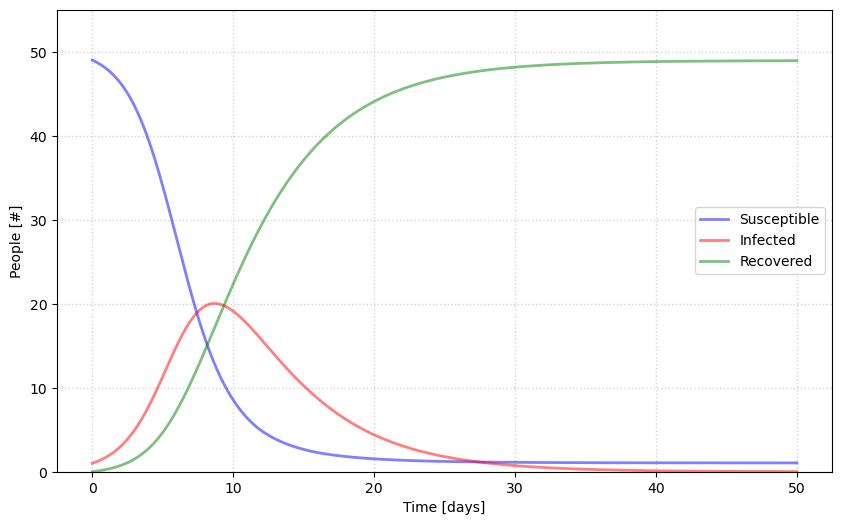

In [17]:
beta  = 5 / (40*8)
gamma = 3/15
runSIR1(beta,gamma,N=50)

Clearly, there must be a lower limit for a decease to spread. This lower limit is the right-hand side
of the differential equation for the infected, which must be positive to growth:
$$
\beta I S - \gamma I > 0
$$
or, after recasting:
$$
\frac{\beta S}{\gamma} > 1
$$
Test with small $\beta$ ...

0.765625


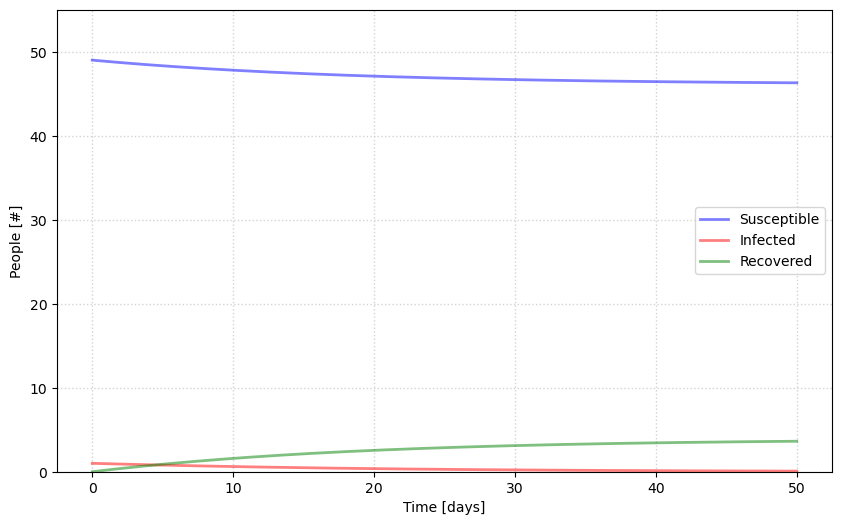

In [18]:
beta  = 1 / (40*8)
gamma = 3/15
N = 50
I0 = 1
R0 = 0
S0 = N-I0-R0
print(beta*S0/gamma)
runSIR1(beta,gamma,N=50)

Finally, we wrap this as interactive model into the `widgets` function of the `pywidgets`package. 

In [19]:
# call interactive module
w = dict(
beta=widgets.FloatSlider(min=0.001,max=0.05,step=0.01,value=0.03,description='beta'),
gamma=widgets.FloatSlider(min=0.1,max=0.5,step=0.01,value=0.2,description='gamma'),
tmax=widgets.IntSlider(min=10,max=100,step=10,value=60,description='Days'))

output = widgets.interactive_output(runSIR1, w)
box = widgets.HBox([widgets.VBox([*w.values()]), output])
display(box)

----
## Loss of immunity

If the recovered persons loose their immunity after a crertain period, we need to add/subtract
another term to the three equations:
$$
\begin{array}{rcl}
{{dS} \over {dt}} & = & - \lambda(I) S + \nu R, \\
{{dI} \over {dt}} & = & + \lambda(I) S - \gamma I, \\
{{dR} \over {dt}} & = & + \gamma I - \nu R, \\
\end{array}
$$
with $\nu$ [1/day] the loss-of-immunity rate, e.g. $\nu=1/50$.

In [12]:
def rhs2(y, t, beta, gamma, nu):
    S, I, R = y
    dSdt = -beta * S * I + nu*R
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I - nu*R
    return dSdt, dIdt, dRdt

def SIRmodel2(beta,gamma,nu,tmax=50,N=50):
    # Total population, N.
    # Initial number of infected and recovered individuals, I0 and R0.
    I0, R0 = 1, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    #beta, gamma = 2.2, 1./28
    # A grid of time points (in days)
    t = np.linspace(0, tmax, 5*tmax)
    # The SIR model differential equations.
    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = integrate.odeint(rhs2, y0, t, args=(beta, gamma,nu))
    S, I, R = ret.T
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    plt.figure(figsize=(10.0,6.0))
    plt.xlabel('Time [days]')
    plt.ylabel('People [#]')
    plt.ylim([0,1.1*N])
    plt.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    plt.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
    plt.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered')
    plt.grid(which='major', c='lightgrey', lw=1, ls=':')
    plt.legend()
    plt.show()

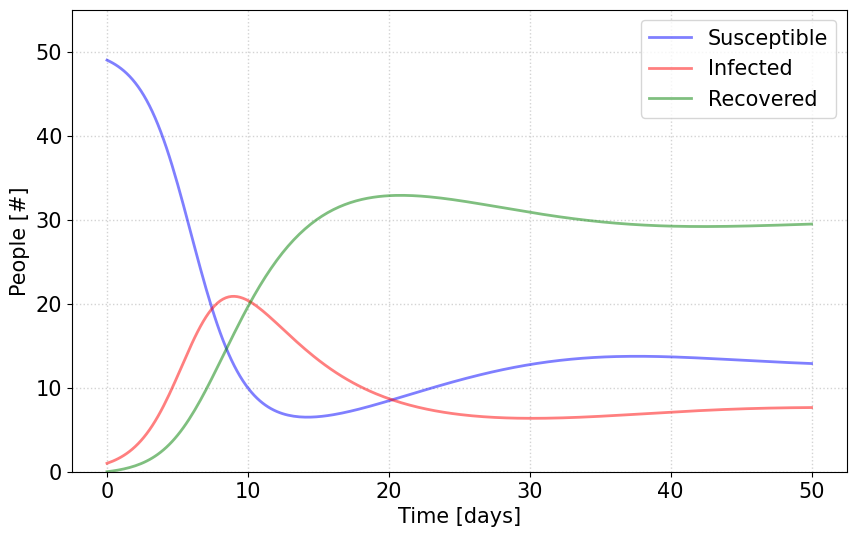

In [13]:
beta  = 5 / (40*8)
gamma = 3/15
nu    = 1/20
SIRmodel2(beta,gamma,nu,N=50)

----
## Vaccination
Vaccination can also be added by adding another parameter, the number of vaccinationed 
peaple $V$, and reducing the susceptible term:
$$
\begin{array}{rcl}
{{dS} \over {dt}} & = & - \lambda(I) S + \nu R - p S, \\
{{dV} \over {dt}} & = & p S, \\
{{dI} \over {dt}} & = & + \lambda(I) S - \gamma I, \\
{{dR} \over {dt}} & = & + \gamma I - \nu R, \\
\end{array}
$$
with $p$ the vaccination rate.

In [14]:
def rhs3(y, t, beta, gamma, nu, p):
    S, I, R, V = y
    dSdt = -beta * S * I + nu*R - p*S
    dVdt = p*S
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I - nu*R
    return dSdt, dIdt, dRdt, dVdt

def SIRmodel3(beta,gamma,nu,p,tmax=50,N=50):
    # Total population, N.
    # Initial number of infected and recovered individuals, I0 and R0.
    I0, R0, V0 = 1, 0, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    #beta, gamma = 2.2, 1./28
    # A grid of time points (in days)
    t = np.linspace(0, tmax, 5*tmax)
    # The SIR model differential equations.
    # Initial conditions vector
    y0 = S0, I0, R0, V0
    # Integrate the SIR equations over the time grid, t.
    ret = integrate.odeint(rhs3, y0, t, args=(beta, gamma,nu,p))
    S, I, R, V = ret.T
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    plt.figure(figsize=(10.0,6.0))
    plt.xlabel('Time [days]')
    plt.ylabel('People [#]')
    plt.ylim([0,1.1*N])
    plt.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    plt.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
    plt.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered')
    plt.plot(t, V, 'black', alpha=0.5, lw=2, label='Vaccinated')
    plt.grid(which='major', c='lightgrey', lw=1, ls=':')
    plt.legend()
    plt.show()

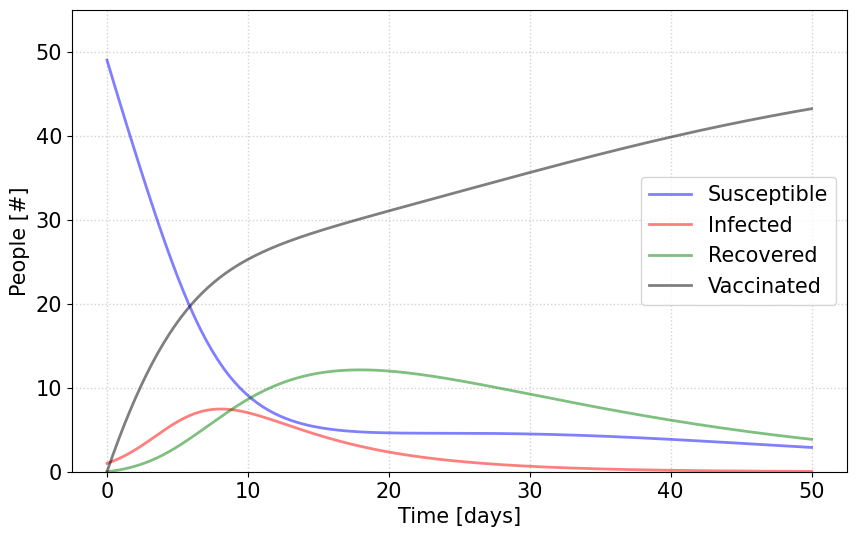

In [15]:
beta  = 5 / (40*8)
gamma = 3/15
nu    = 1/20
p     = 0.1
SIRmodel3(beta,gamma,nu,p,N=50)

[back to top](#top)

# <a id="SEIR">SEIR model</a>

The **SEIR** model describes how a dicease spreads in a population from *healty* individuals to *invected* persons to *immune* people. 

**SEIR** stands for *Susceptible – Exposed - Infectious – Recovered*, it is a box model. We define $N$ as
the total number of individuals.

Then the number of people *susceptible* to the infection, the number of people *exposed*,
the number of people *invected*, and the number of people *recovered and immune* are given as time functions:

- $S(t)$: Number of susceptible people [1/number]

- $E(t)$: Number of exposed people [1/number]

- $I(t)$: Number of invected people [1/number]

- $R(t)$: Number of recovered people [1/number]

with $t$ the time.

For the total number of people $N$, we define:
$$
N = S(t)+E(t)+I(t)+R(t)
$$

During the invection, people move from compartment $S$ via compartments $E$ and $I$ to compartment $R$.
This is described by the following set of **coupled ordinary differential equation of first order**:
$$
\begin{array}{rcl}
{{dS} \over {dt}} & = & - {{R_t} \over {T_{inf}}} I S, \\
{{dE} \over {dt}} & = & + {{R_t} \over {T_{inf}}} I S - {{1} \over {T_{inc}}} E, \\
{{dI} \over {dt}} & = & + {{1} \over {T_{inc}}} E - {{1} \over {T_{inf}}} I, \\
{{dR} \over {dt}} & = & + {{1} \over {T_{inf}}} I, \\
\end{array}
$$
with $R_t$ [1/number] the *transmission rate* (often called $R_0$ in the literature), 
$T_{inf}$ [days] the *incubation period*,
and $T_{inc}$ [days] the *infectious period*.

In [18]:
def SEIRmodel(Rt,Tinf,Tinc,tmax):
    # Total population, N.
    N = 1000
    # Initial number of infected and recovered individuals, I0 and R0.
    E0, I0, R0 = 0, 1, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0 - E0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    #beta, gamma = 2.2, 1./28
    # A grid of time points (in days)
    t = np.linspace(0, tmax, 5*tmax)
    # The SIR model differential equations.
    # Initial conditions vector
    y0 = S0, E0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = integrate.odeint(rhs, y0, t, args=(Rt,Tinf,Tinc))
    S, E, I, R = ret.T
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    plt.figure(figsize=(10.0,6.0))
    plt.xlabel('Time [days]')
    plt.ylabel('People [%]')
    plt.ylim([0,110])
    plt.plot(t, 100*S/N, 'black', alpha=0.5, lw=2, label='Susceptible')
    plt.plot(t, 100*E/N, 'b', alpha=0.5, lw=2, label='Exposed')
    plt.fill_between(t, 100*I/N, 'r', alpha=0.5, lw=2, label='Infected')
    plt.plot(t, 100*R/N, 'g', alpha=0.5, lw=2, label='Recovered')
    plt.grid(which='major', c='lightgrey', lw=1, ls=':')
    plt.legend()
    plt.show()

def rhs(y, t, Rt,Tinf,Tinc):
    S, E, I, R = y
    dSdt = -Rt/Tinf*S*I
    dEdt = Rt/Tinf*I*S - E/Tinc
    dIdt = E/Tinc - I/Tinf
    dRdt = I/Tinf
    return dSdt, dEdt, dIdt, dRdt

# call interactive module
w = dict(
Rt=widgets.FloatSlider(min=0.1,max=10,step=0.1,value=2.20,description='Rt',continuous_update=False),
Tinc=widgets.FloatSlider(min=0.1,max=30,step=0.1,value=5.2,description='Tinc',continuous_update=False),
Tinf=widgets.FloatSlider(min=0.1,max=30,step=0.1,value=2.9,description='Tinf',continuous_update=False),
tmax=widgets.IntSlider(min=20,max=300,step=10,value=160,description='Days'))

output = widgets.interactive_output(SEIRmodel, w)
box = widgets.HBox([widgets.VBox([*w.values()]), output])
display(box)

#SEIRmodel(Rt,Tinf,Tinc,tmax)

[back to top](#top)